Acknowledgement: [https://www.kaggle.com/code/cdeotte/xgb-w-tabm-pseudo-labels-cv-8-60](https://www.kaggle.com/code/cdeotte/xgb-w-tabm-pseudo-labels-cv-8-60)

# CATBoost with TabM Pseudo Labels!
In this starter notebook, we demonstrate the following
* TabM model
* CATBoost model
* Basic feature engineering
* Pseudo label validation and test data
* Train CAT with TabM pseudo label data

# Import Libraries

In [1]:
!pip install pytabkit

import pandas as pd, numpy as np, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

import torch
from pytabkit import TabM_D_Regressor

import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 7.4 MB/s eta 0:00:00:00:01


In [2]:
import catboost as cat
print(f"CATBoost version: {cat.__version__}")

import importlib.metadata
print(f"TabM version: {importlib.metadata.version('pytabkit')}")

CATBoost version: 1.2.8
TabM version: 1.7.3


# Load Data
We load train, test, and original dataset.

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")
print("Train shape:", train.shape )
train.head(1)

Train shape: (630000, 13)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3


In [4]:
test = pd.read_csv("/kaggle/input/playground-series-s6e1/test.csv")
print("Test shape:", test.shape )
test.head(1)

Test shape: (270000, 12)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy


In [5]:
orig = pd.read_csv("/kaggle/input/exam-score-prediction-dataset/Exam_Score_Prediction.csv")
print("Original data shape:", orig.shape )
orig.head(1)

Original data shape: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9


# Basic Feature Engineering
We engineer two things. First, we create a new feature called "formula" based on Kaggler Broccoli Beef's discussion [here][1]. Second, we encode the given 11 features as both ordinal numbers and categories for XGB's default categorical handling and TabM's categorical handling.

[1]: https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915

In [6]:
TARGET = "exam_score"
CATS = ["gender","course","internet_access","study_method","sleep_quality","facility_rating","exam_difficulty"]
FEATURES = ['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
print(f"There are {len(FEATURES)} features.")

There are 11 features.


In [7]:
# https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
def formula(df):
    f = (6*df.study_hours + 0.35*df.class_attendance + 1.5*df.sleep_hours +
                 5*(df.sleep_quality=='good') + -5*(df.sleep_quality=='poor') +
                 10*(df.study_method=='coaching') + 5*(df.study_method=='mixed') + 2*(df.study_method=='group study') + 1*(df.study_method=='online videos') +
                 4*(df.facility_rating=='high') + -4*(df.facility_rating=='low') )
    return f

for df in [train, test, orig]:
    df['formula'] = formula(df)

In [8]:
ordinal_maps = {
    "gender" : {"male":0, "female":1, "other":2},
    "internet_access" : {"no":0, "yes":1},
    "sleep_quality" : {"poor":0, "average":1, "good":2},
    "facility_rating" : {"low":0, "medium":1, "high":2},
    "exam_difficulty" : {"easy":0, "moderate":1, "hard":2},
    "course" : {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
    "study_method" : {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
}

for df in [train, test, orig]:
    for c in CATS:
        df[c] = df[c].map(ordinal_maps[c]).fillna(-1).astype('int32')

In [9]:
NEW_CATS = []
for c in FEATURES:
    n = f"CAT_{c}"
    NEW_CATS.append(n)
    
    train[n] = train[c].copy()
    test[n] = test[c].copy()
    orig[n] = orig[c].copy()

    combine = pd.concat([train[n],test[n],orig[n]],axis=0)
    v,_ = combine.factorize()
    train[n] = v[:len(train)]
    test[n] = v[len(train):len(train)+len(test)]
    orig[n] = v[len(train)+len(test):]
    for df in [train, test, orig]:
        df[n] = df[n].astype("int32")

FEATURES += ['formula'] + NEW_CATS
print(f"Now there are {len(FEATURES)} features.")

Now there are 23 features.


# CATBoost w/ TabM Pseudo Labels
We train XGBoost using pseudo labels on validation and test data from TabM.

In [10]:
catb_params = {
    "iterations": 10_000,
    "learning_rate": 0.01,
    "max_depth": 8,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.8,
    "min_child_samples": 5,
    "early_stopping_rounds": 100,
    "eval_metric": "RMSE",
    "task_type": "GPU",
    "devices": "0",
    "random_state": 42,
    "verbose": 200,
}

tabm_params = {
    "verbosity": 0,
    "arch_type": "tabm-mini-normal",
    "tabm_k": 24, 
    "num_emb_type": "pwl", 
    "d_embedding": 8,
    "batch_size": 256,
    "lr": 1e-3, 
    "n_epochs": 100, 
    "dropout": 0.11, 
    "d_block": 256, 
    "n_blocks": 5, 
    "patience": 4, 
    "weight_decay": 1e-2, 
    "device": "cuda",
    "random_state": 42,
}

In [11]:
N_SPLITS = 10

# PREPARE DATA
X = train[FEATURES]
X_test = test[FEATURES]
X_orig = orig[FEATURES]
y = train[TARGET].values
y_orig = orig[TARGET].values

# STORE OOF AND TEST PREDS
oof_preds_catb = np.zeros(len(train))
test_preds_catb = np.zeros(len(test))

# KFOLD TRAIN AND VALIDATE
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print("#"*25)
    print(f"### FOLD {fold}")
    print("#"*25)

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # ADD ORIGINAL DATA
    X_train = pd.concat([X_train, X_orig], axis=0)
    y_train = np.concatenate([y_train, y_orig], axis=0)

    # TRAIN TABM
    model = TabM_D_Regressor(**tabm_params)
    model.fit(
        X_train, y_train,
        X_val, y_val,
        cat_col_names=NEW_CATS,
    )
    oof_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    # PSEUDO LABEL WITH TABM FOR CATBOOST
    X_train_catb = pd.concat([X_train, X_val, X_test], axis=0)
    y_train_catb = np.concatenate([y_train, oof_preds, test_preds], axis=0)

    # PREPARE CATS FOR CATBOOST
    cat_indices = [X_train_catb.columns.get_loc(c) for c in NEW_CATS]
    
    X_val_catb = X_train_catb.iloc[len(X_train):len(X_train)+len(X_val)]
    X_test_catb = X_train_catb.iloc[len(X_train)+len(X_val):]

    # TRAIN CATBOOST WITH PSEUDO LABELS
    model = CatBoostRegressor(**catb_params)
    model.fit(
        X_train_catb,
        y_train_catb,
        eval_set=[(X_val_catb, y_val)],
        cat_features=cat_indices,
    )

    oof_preds = model.predict(X_val_catb)
    oof_preds_catb[val_idx] = oof_preds
    rmse_catb = mean_squared_error(y_val, oof_preds)**0.5
    print(f"Fold {fold} RMSE CatBoost w/ Pseudo: {rmse_catb:.5f}")

    test_preds = model.predict(X_test_catb)
    test_preds_catb += test_preds / N_SPLITS

    # CLEAR MEMORY
    gc.collect()
    torch.cuda.empty_cache()

# OVERALL CV SCORE
print("-" * 40)
rmse_catb = mean_squared_error(y, oof_preds_catb)**0.5
print(f"OOF RMSE CatBoost w/ Pseudo:  {rmse_catb:.5f}")
print()

#########################
### FOLD 1
#########################
0:	learn: 18.0119680	test: 18.7132565	best: 18.7132565 (0)	total: 305ms	remaining: 50m 52s
200:	learn: 7.6332639	test: 9.1588049	best: 9.1588049 (200)	total: 36.5s	remaining: 29m 38s
400:	learn: 7.2298890	test: 8.8242420	best: 8.8242420 (400)	total: 1m 14s	remaining: 29m 50s
600:	learn: 7.1882498	test: 8.7911671	best: 8.7911671 (600)	total: 1m 49s	remaining: 28m 28s
800:	learn: 7.1644852	test: 8.7724668	best: 8.7724668 (800)	total: 2m 24s	remaining: 27m 36s
1000:	learn: 7.1445753	test: 8.7566288	best: 8.7566288 (1000)	total: 2m 58s	remaining: 26m 46s
1200:	learn: 7.1278538	test: 8.7438514	best: 8.7438514 (1200)	total: 3m 33s	remaining: 26m 4s
1400:	learn: 7.1134685	test: 8.7329644	best: 8.7329644 (1400)	total: 4m 8s	remaining: 25m 23s
1600:	learn: 7.0997410	test: 8.7223163	best: 8.7223163 (1600)	total: 4m 43s	remaining: 24m 47s
1800:	learn: 7.0877291	test: 8.7132211	best: 8.7132211 (1800)	total: 5m 18s	remaining: 24m 10s
20

# CATBoost Feature Importance

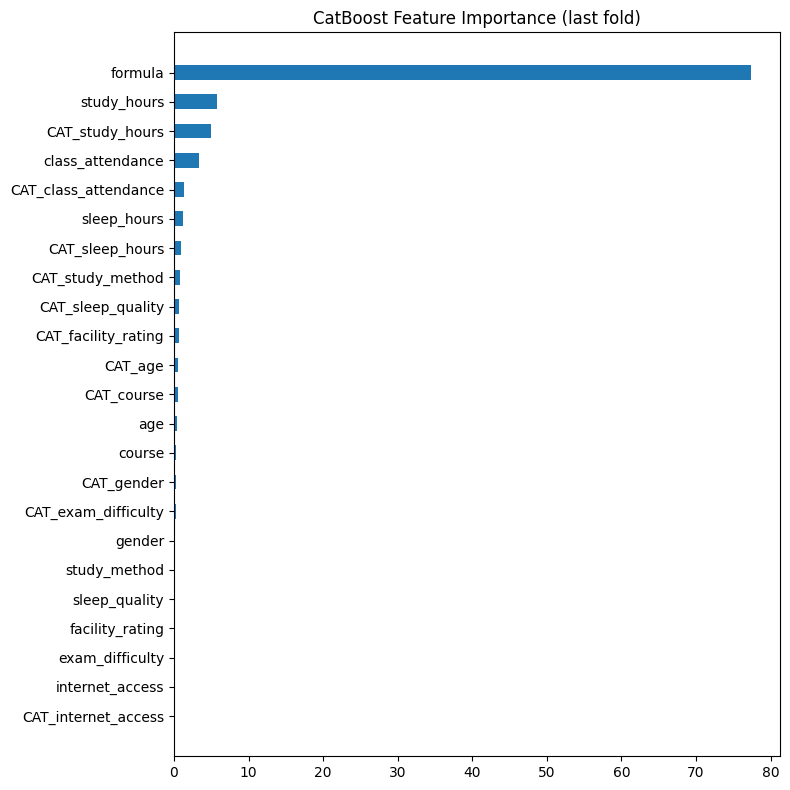

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
importances = model.get_feature_importance()
indices = np.argsort(importances)[-40:]
ax.barh(range(len(indices)), importances[indices], height=0.5)
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([X_train_catb.columns[i] for i in indices])
ax.set_title("CatBoost Feature Importance (last fold)")
fig.tight_layout()
plt.show()

# Compute CV Score

In [13]:
np.save("oof_catb", oof_preds_catb)
np.save("test_preds_catb", test_preds_catb)

# Create Submission CSV

In [14]:
sub = pd.read_csv("/kaggle/input/playground-series-s6e1/sample_submission.csv")
sub['exam_score'] = np.clip(test_preds_catb, 19.6, 100)
sub.to_csv("submission.csv", index=False)
sub.head()

,id,exam_score
0,630000,70.354688
1,630001,67.720560
2,630002,89.282090
3,630003,56.511520
4,630004,46.250888


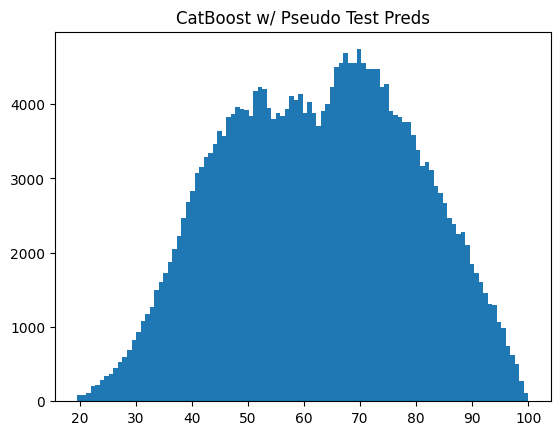

In [ ]:
plt.hist(sub['exam_score'], bins=100)
plt.title("CatBoost w/ Pseudo Test Preds")
plt.show()